# Análisis de MNIST con tf.keras, tf.data y eager execution

**Profesor:** Roberto Muñoz <br />
**E-mail:** <rmunoz@metricarts.com> <br />

**Colaborador:** Sebastián Arpón <br />
**E-mail:** <rmunoz@metricarts.com> <br />

Fuente: https://medium.com/mostly-ai/tensorflow-records-what-they-are-and-how-to-use-them-c46bc4bbb564

En este laboratorio aprendemos acerca del uso del módulo tf.Record

# Escritura

Supongamos que tenemos el siguiente ejemplo que queremos transformar a formato **TFRecord**

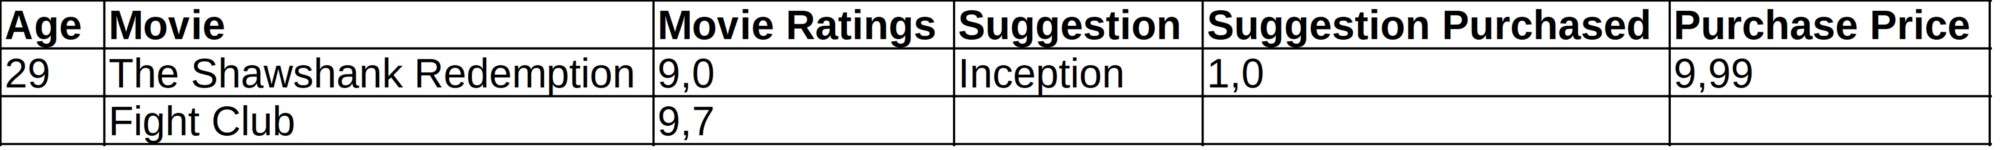

Tenemos un numero de atributos (features), cada uno siendo una lista que tiene el mismo tipo de datos. Para guardar estos atributos en un TFRecord, primero necesitamos crear la lista que constituye los atributos.
**tf.train.BytesList**, **tf.train.FloatList**, and **tf.train.Int64List** estan en el core de **tf.train.Feature**. Todas estas tres tiene un unico atributo el cual es una lista con los respectivos bytes, float o int.

In [1]:
import tensorflow as tf

movie_name_list = tf.train.BytesList(value=[b'The Shawshank Redemption', b'Fight Club'])

movie_rating_list = tf.train.FloatList(value=[9.0, 9.7])

**tf.train.Feature** empaque una lista de datos de un tipo especifico de forma tal de que TensorFlow pueda entenderlo. Tiene una unica entrada, que son una union de listas de tipo bytes, float o int64. Siendo una union, la lista guardada puede resultar del tipo tf.train.BytesList, tf.train.FloatList , o tf.train.Int64List

In [2]:
movie_names = tf.train.Feature(bytes_list=movie_name_list)

movie_ratings = tf.train.Feature(float_list=movie_rating_list)

**tf.train.Features** es una coleccion de feature. Tiene un unica entrada un diccionario que como key tiene el nu=ombre del feature y como valor un **tf.train.Feature**.

In [3]:
movie_dict = {

  'Movie Names': movie_names,

  'Movie Ratings': movie_ratings

}

movies = tf.train.Features(feature=movie_dict)

**tf.train.Example** es uno de los principales componentes que estructuran un TFRecord. Un **tf.train.Example** guarda los atributos "de un ejemplo" (#NO ESTOY SEGURO DE ESTO HAY QUE CONFIRMAR LO QUE ESTA ENTRE COMILLAS!!!) en un unico atributo del tipo **tf.train.Features**.

In [4]:
example = tf.train.Example(features=movies)

Para escribir el **tf.train.Example** utilizamos la clase **tf.python_io.TFRecordWriter** con el metodo **write** el cual accepta como input un string para escribirlo en disco, lo cual significa que primero tenemos que serializar el **tf.train.Example** primero.

In [5]:
with tf.python_io.TFRecordWriter('results/movie_ratings.tfrecord') as writer:

  writer.write(example.SerializeToString())

# Lectura

Para leer nuestra data necesitamos
1) Leer el archivo TFRecord usando un **tf.TFRecordReader**.
2) Definir los tipos de atributos que recibiras del **TFRecord** usando **tf.FixedLenFeature** y **tf.VarLenFeature**, dependiendo del tipo de data que contiene cada atributo.
3) REVISAR TRADUCCION (Parse one tf.train.Example (one file) a time using tf.parse_single_example.)

In [6]:
tfrecord_file='results/movie_ratings.tfrecord'

sess = tf.InteractiveSession()

# Read TFRecord file
reader = tf.TFRecordReader()
filename_queue = tf.train.string_input_producer([tfrecord_file])

_, serialized_example = reader.read(filename_queue)

# Define features
read_features = {
    'Movie Names': tf.VarLenFeature(dtype=tf.string),
    'Movie Ratings': tf.VarLenFeature(dtype=tf.float32)}

# Extract features from serialized data
read_data = tf.parse_single_example(serialized=serialized_example,
                                    features=read_features)

# Many tf.train functions use tf.train.QueueRunner,
# so we need to start it before we read
tf.train.start_queue_runners(sess)

# Print features
for name, tensor in read_data.items():
    print('{}: {}'.format(name, tensor.eval()))

Movie Names: SparseTensorValue(indices=array([[0],
       [1]]), values=array([b'The Shawshank Redemption', b'Fight Club'], dtype=object), dense_shape=array([2]))
Movie Ratings: SparseTensorValue(indices=array([[0],
       [1]]), values=array([ 9.        ,  9.69999981], dtype=float32), dense_shape=array([2]))
